In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

C:\Users\wj\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data_x = pd.read_csv("./data/practice/acic_practice_0001.csv")
data_y = pd.read_csv("./data/practice_year/acic_practice_year_0001.csv")

# propensity score

In [3]:
data_z = pd.merge(data_x, data_y[['id.practice','Z']].drop_duplicates(), on='id.practice')
df = data_z
ct = ['X2','X4']
for c in ct:
    df[c] = df[c].astype('category')

debias_m = LGBMClassifier(max_depth=3)

X = ['X1','X2','X3','X4','X5','X6','X7','X8','X9']
T = ['Z']

In [4]:
debias_m = LGBMClassifier(objective = 'binary',
                         is_unbalance = True,
                         #metric = 'log_loss',
                         metric = 'binary_logloss,auc',
                         max_depth = 6,
                         num_leaves = 20,
                         learning_rate = 0.1,
                         #feature_fraction = 0.7,
                         min_child_samples=21,
                         min_child_weight=0.001,
                         #bagging = 1,
                         #subsample_freq = 2,
                         reg_alpha = 0.002,
                         reg_lambda = 10,
                         cat_smooth = 0,
                         n_estimators = 200,   
                        )

ps = cross_val_predict(debias_m, data_z[X], data_z[T].values.ravel(), cv=10, method='predict_proba')[:,1]
#ps_res =  df[T] - cross_val_predict(debias_m, df[X], df[T].values.ravel(), cv=5, method='predict_proba')[:,1].reshape(-1,1) + df[T].mean()
data_x = data_x.assign(ps = ps)
data_z = data_z.assign(ps = ps)

# Year average

In [5]:
data_o = pd.merge(data_x, data_y, on='id.practice')
df = data_o
ct = ['X2','X4']
for c in ct:
    df[c] = df[c].astype('category')
    
#XV = df.columns.drop(['id.practice','year','post','Z','n.patients'])
V = ['V1_avg', 'V2_avg', 'V3_avg', 'V4_avg', 'V5_A_avg', 'V5_B_avg', 'V5_C_avg']
XV = V + X
Y = ['Y']

In [34]:
means = []
for i in range(1,5):
    means.append(np.average(df[(df['year'] == i) & (df['Z'] == 0)]['Y'], weights = df[(df['year'] == i) & (df['Z'] == 0)]['n.patients']))
    print(means[i-1])

avgs = pd.DataFrame({'year': [1, 2, 3, 4], 'ft': means})
df = pd.merge(df, avgs, on='year')

df_34 = df[df['year'] >= 3]

for i in [1,2,3,4]:
    print(np.average(df[(df['year'] == i) & (df['Z'] == 1)]['Y'], weights = df[(df['year'] == i) & (df['Z'] == 1)]['n.patients']))

865.3614330552035
1006.572361414004
1127.312134618135
1247.3123710094226
867.6927807920633
1087.793746374329
1213.996301442881
1339.7549908514943


In [36]:
for i in [1,2]:
    print(np.average(df[(df['year'] == i)]['Y'], weights = df[(df['year'] == i)]['n.patients']))

866.4015254031086
1042.6514616793997


# correction:
df_i[y_adj] = df_i[ft] + (df_i[Y] - df_i[ft] + df_1[Y] - df_1[ft] + df_2[Y] - df_2[ft])/3

In [7]:
denoise_m = LGBMRegressor(is_unbalance = True,
                         #metric = 'log_loss',
                         metric = 'l2',
                         max_depth = -1,
                         num_leaves = 20,
                         learning_rate = 0.1,
                         #feature_fraction = 0.7,
                         min_child_samples=21,
                         min_child_weight=0.001,
                         #bagging = 1,
                         #subsample_freq = 2,
                         reg_alpha = 0.002,
                         reg_lambda = 10,
                         cat_smooth = 0,
                         n_estimators = 200,   
                        )

# \hat{\mu_0(v)+e(x)r(x)+f(t)}
#pred3 = cross_val_predict(denoise_m, df_3[V], df_3[Y].values.ravel(), cv=10, method='predict_proba')[:,1]
#pred4 = cross_val_predict(denoise_m, df_4[V], df_4[Y].values.ravel(), cv=10, method='predict_proba')[:,1]

#df_1 = df[df['year'] == 1]
#df_2 = df[df['year'] == 2]
df_34 = df[df['year'] >= 3]
#df_34 = df_34.assign(y_adj=df_i[ft] + (df_i[Y] - df_i[ft] + df_1[Y] - df_1[ft] + df_2[Y] - df_2[ft])/3)
pred_M = cross_val_predict(denoise_m, df_34[XV], df_34['Y']-df_34['ft'], fit_params={'sample_weight':df_34['n.patients']}, cv=10)

In [8]:
df_34[V][300:1000].shape

(700, 7)

In [31]:
import lightgbm as lgb

lgb_train = lgb.Dataset(df_34[XV][0:800], df_34['Y'][0:800]-df_34['ft'][0:800])
lgb_test = lgb.Dataset(df_34[XV][800:1000], df_34['Y'][800:1000]-df_34['ft'][800:1000])
evals_result={}

params = {
    'max_depth':8,
    'num_leaves': 31,
    'metric': ('auc','l2'),#可以设置多个评价指标
    'verbose': 0
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=[lgb_train, lgb_test],
                evals_result=evals_result,#非常重要的参数,一定要明确设置
                verbose_eval=10)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

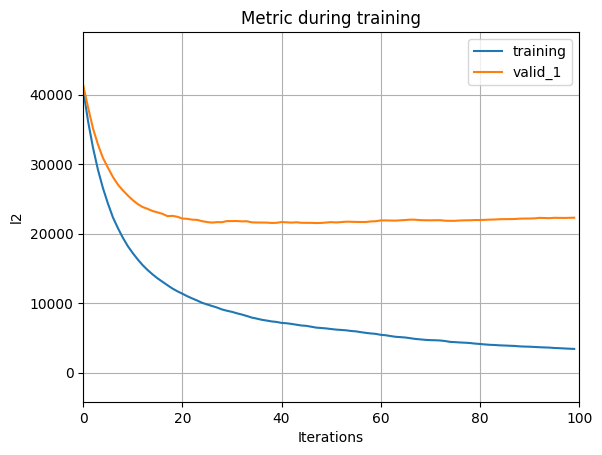

In [32]:
ax = lgb.plot_metric(evals_result, metric='l2')#metric的值与之前的params里面的值对应
plt.show()

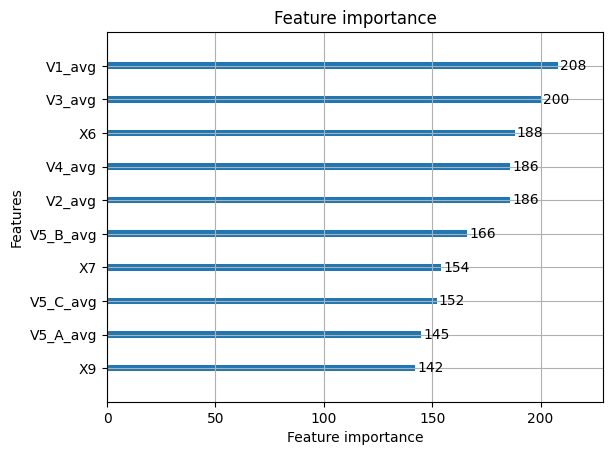

In [33]:
ax = lgb.plot_importance(gbm, max_num_features=10)#max_features表示最多展示出前10个重要性特征，可以自行设置
plt.show()

In [12]:
import graphviz

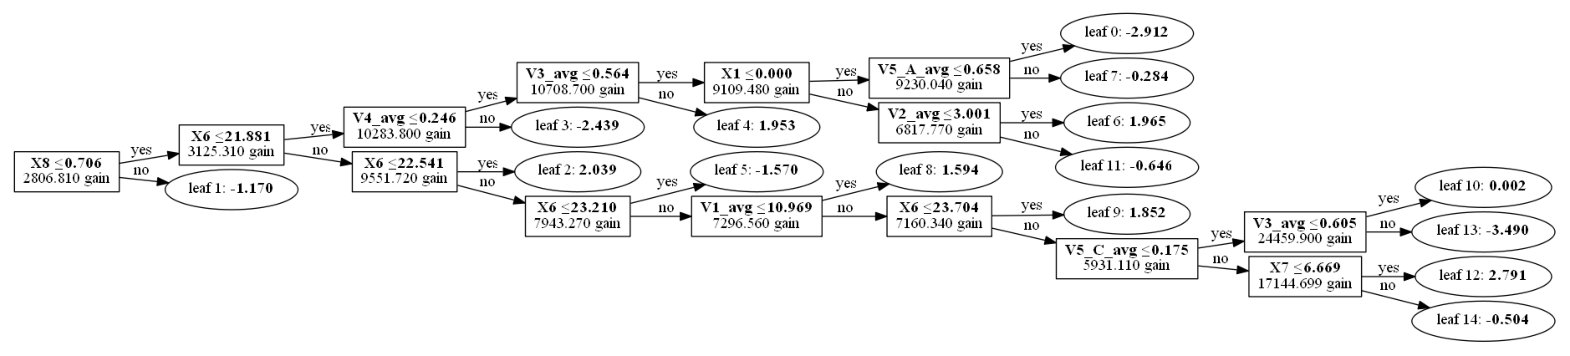

In [23]:
ax = lgb.plot_tree(gbm, tree_index=99, figsize=(20, 8), show_info=['split_gain'])
plt.show()